# **Step 1 : Binomial Model**

In [1]:
#import libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# Parameters
S0 = 100        # Initial stock price
r = 0.05        # Risk-free rate
sigma = 0.25    # Volatility
T = 3 / 12      # Time to expiration in years (3 months)
K = 100         # Strike price (ATM option)
n_steps = 100   # Number of steps in the binomial tree

**5. European Call & Put Options**

In [3]:
# Binomial tree parameters
dt = T / n_steps  # Time step
u = np.exp(sigma * np.sqrt(dt))     # Up factor
d = 1 / u                           # Down factor
p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

# Generate terminal payoffs
def binomial_tree_european_option(S0, K, r, T, sigma, n_steps, option_type="call"):
    # Create an array for asset prices at maturity
    asset_prices = np.zeros(n_steps + 1)
    for i in range(n_steps + 1):
        asset_prices[i] = S0 * (u ** (n_steps - i)) * (d ** i)

    # Option payoffs at maturity
    if option_type == "call":
        option_values = np.maximum(asset_prices - K, 0)
    elif option_type == "put":
        option_values = np.maximum(K - asset_prices, 0)

    # Discount back through the tree
    for j in range(n_steps - 1, -1, -1):
        for i in range(j + 1):
            option_values[i] = np.exp(-r * dt) * (p * option_values[i] + (1 - p) * option_values[i + 1])

    return option_values[0]  # Return the option price at the root

In [4]:
# Price ATM European Call and Put
european_call_price = binomial_tree_european_option(S0, K, r, T, sigma, n_steps, "call")
european_put_price = binomial_tree_european_option(S0, K, r, T, sigma, n_steps, "put")
parity_difference = european_call_price - european_put_price - (S0 - K * np.exp(-r * T))
print(f"ATM European Call Price: {european_call_price:.2f}")
print(f"ATM European Put Price: {european_put_price:.2f}")
print(f"Put-Call Parity Difference: {parity_difference:.4f}")

ATM European Call Price: 5.59
ATM European Put Price: 4.34
Put-Call Parity Difference: -0.0000


**6. Delta for European Call and Put Options**

In [5]:
# Compute Delta for Call and Put
S0_up = S0 * 1.01  # 1% up move
S0_down = S0 * 0.99  # 1% down move
european_call_price_up = binomial_tree_european_option(S0_up, K, r, T, sigma, n_steps, "call")
european_call_price_down = binomial_tree_european_option(S0_down, K, r, T, sigma, n_steps, "call")
european_put_price_up = binomial_tree_european_option(S0_up, K, r, T, sigma, n_steps, "put")
european_put_price_down = binomial_tree_european_option(S0_down, K, r, T, sigma, n_steps, "put")

In [6]:
# Call Delta and Put Delta
european_call_delta = (european_call_price_up - european_call_price_down) / (S0_up - S0_down)
european_put_delta = (european_put_price_up - european_put_price_down) / (S0_up - S0_down)
print(f"European Call Delta: {european_call_delta:.4f}")
print(f"European Put Delta: {european_put_delta:.4f}")

European Call Delta: 0.5644
European Put Delta: -0.4356


**7. European Call & Put Options Sensitivity to Volatility**

In [7]:
# Update volatility(vega)  by 5%
sigma_new = sigma * 1.25  # 25% increase in volatility
call_price_high_vol = binomial_tree_european_option(S0, K, r, T, sigma_new, n_steps, "call")
put_price_high_vol = binomial_tree_european_option(S0, K, r, T, sigma_new, n_steps, "put")

In [8]:
# Vega For Call and Put
european_call_vega = (call_price_high_vol - european_call_price) / (sigma_new - sigma)
european_put_vega = (put_price_high_vol - european_put_price) / (sigma_new - sigma)
print(f"European Call Vega: {european_call_vega:.4f}")
print(f"European Put Vega: {european_put_vega:.4f}")

European Call Vega: 0.0000
European Put Vega: 0.0000


**8. American Call & Put Options**

For an option to be at-the-money (ATM), the initial underlying stock price,  S_ini_  must be equal to the Strike Price,  K

**Parameters:**

- S_ini_ = 100  (Initial stock price)
- r = 0.05  (Risk-free rate)
- sigma = 0.20  (Volatility)
- T = 3/12  (Time to expiration in years (3 months))
- K = 100  (Strike price)

In [9]:
def binomial_tree_american_option(S_ini, K, T, r, sigma, N, option_type):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price

    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        if option_type == "C":
            C[N, i] = max(S[N, i] - K, 0)
        else:
            C[N, i] = max(K - S[N, i], 0)

    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (
                p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i]
            )  # Computing the European option prices
            S[j, i] = (
                S_ini * (u ** (i)) * (d ** (j - i))
            )  # Underlying evolution for each node
            if option_type == "C":
                C[j, i] = max(
                    C[j, i], S[j, i] - K
                )  # Decision between the European option price and the payoff from early-exercise
            else:
                C[j, i] = max(
                    C[j, i], K - S[j, i]
                )  # Decision between the European option price and the payoff from early-exercise

    return C[0, 0], C, S

In [10]:
# Selecting number of steps, N
price_array = []
for N in [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2500]:
    call_price, C, S =  binomial_tree_american_option(100, 100, 3/12, 0.05, 0.2, N, "C")
    price_array.append(call_price)
    print("With N = {:3d}, the price is {:.2f}".format(N, call_price))

With N =   1, the price is 5.59
With N =  10, the price is 4.52
With N = 100, the price is 4.61
With N = 200, the price is 4.61
With N = 300, the price is 4.61
With N = 400, the price is 4.61
With N = 500, the price is 4.61
With N = 600, the price is 4.61
With N = 700, the price is 4.61
With N = 800, the price is 4.61
With N = 900, the price is 4.61
With N = 1000, the price is 4.61
With N = 1500, the price is 4.61
With N = 2500, the price is 4.61


Call price converges at N = 100 steps. Hence, N = 100 was selected

In [11]:
american_call_price, C, S = binomial_tree_american_option(100, 100, 3/12, 0.05, 0.20, 100, "C")
american_call_price = round(american_call_price, 2)
print("American Call Option Price:", american_call_price)

American Call Option Price: 4.61


In [12]:
american_put_price, C, S = binomial_tree_american_option(100, 100, 3/12, 0.05, 0.20, 100, "P")
american_put_price = round(american_put_price, 2)
print("American Put Option Price:", american_put_price)

American Put Option Price: 3.47


**9. Delta for American Call & Put Options**

In [13]:
def american_option_delta(S_ini, K, T, r, sigma, N, option_type):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta

    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        if option_type == "C":
            C[N, i] = max(S[N, i] - K, 0)
        else:
            C[N, i] = max(K - S[N, i], 0)

    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (
                p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i]
            )  # Computing the European option prices
            S[j, i] = (
                S_ini * (u ** (i)) * (d ** (j - i))
            )  # Underlying evolution for each node
            if option_type == "C":
                C[j, i] = max(
                    C[j, i], S[j, i] - K
                )  # Decision between the American option price and the payoff from early-exercise
            else:
                C[j, i] = max(
                    C[j, i], K - S[j, i]
                )  # Decision between the American option price and the payoff from early-exercise

            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i]
            )  # Computing the delta for each node

    return C[0, 0], C, S, Delta

In [14]:
price, C, S, delta = american_option_delta(100, 100, 3/12, 0.05, 0.2, 100, "C")
print("Delta for American Call Option:", delta.round(4))

Delta for American Call Option: [[0.5693 0.     0.     ... 0.     0.     0.    ]
 [0.529  0.6082 0.     ... 0.     0.     0.    ]
 [0.488  0.5686 0.6464 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 1.     0.     0.    ]
 [0.     0.     0.     ... 1.     1.     0.    ]
 [0.     0.     0.     ... 1.     1.     1.    ]]


Greek Delta for American Call Option is: 0.5693

In [15]:
price, C, S, delta = american_option_delta(100, 100, 3/12, 0.05, 0.2, 100, "P")
print("Delta for American Put Option", delta.round(4))

Delta for American Put Option [[-0.4498  0.      0.     ...  0.      0.      0.    ]
 [-0.4931 -0.4081  0.     ...  0.      0.      0.    ]
 [-0.5374 -0.4503 -0.3673 ...  0.      0.      0.    ]
 ...
 [-1.     -1.     -1.     ...  0.      0.      0.    ]
 [-1.     -1.     -1.     ...  0.      0.      0.    ]
 [-1.     -1.     -1.     ...  0.      0.      0.    ]]


Greek Delta for American Put Option is: -0.4498

**Difference Between Delta for American Call & Put**: While the call option delta is positive (is between 0 and 1), the put option delta holds the reverse position. For a call option price that increases as stock price increase, it expected that its delta will be positive. On the other hand, the put price decreases as the stock price increases.

The delta of an American option pricing helps to assess the position of underlying asset price with intent of minimizing the risks associated with the changes in the underlying stock price. Since early exercise is possible under American option pricing, the option prices become sensitive to changes in stock prices; delta helps us measure this sensitivity of the options to changes in underlying stock prices.



**10. American Call & Put Options Sensitivity to Volatility**

In [16]:
# with sigma= 0.25, American Call Price
american_call_price_new, C, S = binomial_tree_american_option(100, 100, 3/12, 0.05, 0.25, 100, "C")
print(" American Call Option Price:", american_call_price_new.round(2))

 American Call Option Price: 5.59


In [17]:
# with sigma= 0.25, American Put Price
american_put_price_new, C, S = binomial_tree_american_option(100, 100, 3/12, 0.05, 0.25, 100, "P")
print(" American Put Option Price:", american_put_price_new.round(2))

 American Put Option Price: 4.45


In [18]:
# Vega For American Call and Put
american_call_vega = (american_call_price_new - american_call_price) / (sigma_new - sigma)
american_put_vega = (american_put_price_new - american_put_price) / (sigma_new - sigma)
print(f"American Call Vega: {american_call_vega:.4f}")
print(f"American Put Vega: {american_put_vega:.4f}")

American Call Vega: 15.6156
American Put Vega: 15.7254


**11. European Put-Call Parity Graph**

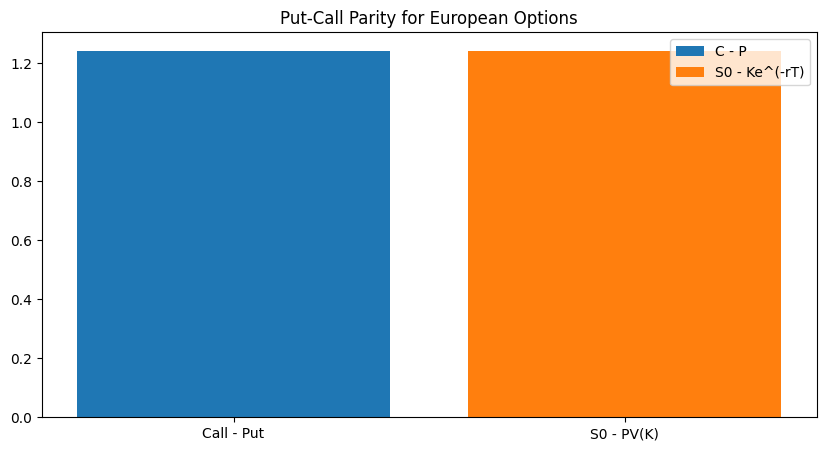

In [19]:
# Plot European Put-Call Parity Verification
plt.figure(figsize=(10, 5))
plt.bar(["Call - Put"], [european_call_price - european_put_price], label="C - P")
plt.bar(["S0 - PV(K)"], [S0 - K * np.exp(-r * T)], label="S0 - Ke^(-rT)")
plt.title("Put-Call Parity for European Options")
plt.legend()
plt.show()

**12. American Put-Call Parity Graph**

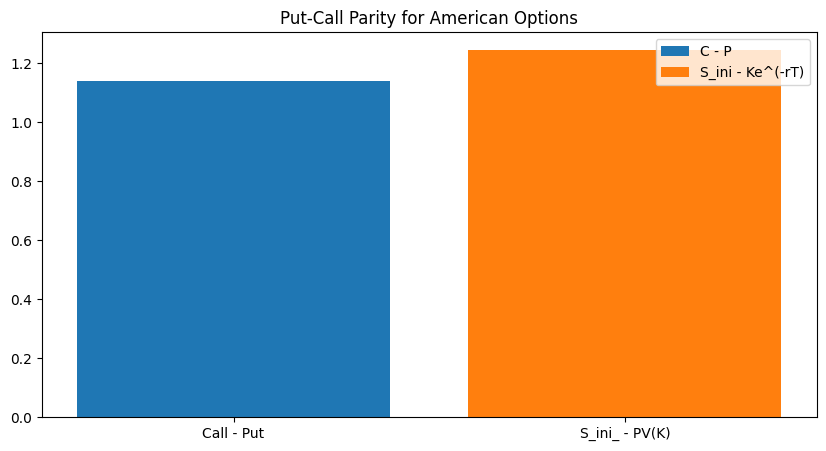

In [20]:
 S_ini_ = 100
 K = 100
#Plot American Put-Call Parity Verification
plt.figure(figsize=(10, 5))
plt.bar(["Call - Put"], [american_call_price - american_put_price], label="C - P")
plt.bar(["S_ini_ - PV(K)"], [S_ini_ - K * np.exp(-r * T)], label="S_ini - Ke^(-rT)")
plt.title("Put-Call Parity for American Options")
plt.legend()
plt.show()

Put-Call Parity does not hold for American Options:

Reason:

- Early Exercise flexibility: The ability to exercise option before expiration  increases the value for both call and put options and in turn alters the balance of the parity equation (as shown in the Fig 2 above) creating an opportunity for arbitrage.

- Intermittent dividend adjustments: Dividend paying stocks tend to optimize the value of American call because of early exercise. Additionally, payment of dividends reduces the underlying stock price, alters parity equilibrium and consequently gives room for arbitrage

**13. European Call vs American call**

In [21]:
# confirm difference between European call and American Call
european_call_price <= american_call_price

False

In [22]:
# European-American Call difference
european_american_call_diff = european_call_price - american_call_price
european_american_call_diff

0.9759735077054357

Unfortunately, in this case, the European call option is greater than American call option. This might have been due to market inefficiences improper market valuation of European call or trading constraints on the flexibility of early exercise of American call options. In the real world setting, transaction costs, bid-asks spread and illiquidity could also impact on trading efficencies of the underlying stock

**14. European Put vs American Put**

In [23]:
# confirm difference between European put and American put
european_put_price <= american_put_price

False

In [24]:
# European-American Put difference
european_american_put_diff = european_put_price - american_put_price
european_american_put_diff

0.8737535570945929

The conventional rule of European Put being less than or equal to the American Put does not hold in this case either.

This could be due to dividend impact on early exercise. American put options can be impacted by dividend payouts and stock volatility- resulting in potential increases in underlying stock prices.

Low interest rates or no immediate put payoff: could cause option investors to value European option more than American put options

# **Step 2 : Trinomial Model**

**15. European Trimonial Call**


**Parameters**

- S_ini_ = 100$       (Initial stock price)

- For Deep ITM: we will consider moneyness (K/S_ini_) of **90%**. (i.e **K = 90**)

- For ITM : we will consider moneyness (K/S_ini_) of **95%** (i.e **K = 95**)

- ATM: K = S_ini_ = **100**

- For OTM: we will consider moneyness (K/S_ini_) of **105%**. (i.e **K = 105**)

- For Deep OTM: we will consider moneyness (K/S_ini_) of **125%** (i.e **K = 110**)

**Parameters**

- $S_ini_ = 100$       (Initial stock price)

- For Deep OTM: we will consider moneyness (K/S_ini_) of **90%**. (i.e **K = 90**)

- For OTM : we will consider moneyness (K/S_ini_) of **95%** (i.e **K = 95**)

- ATM: K = S_ini_ = **100**

- For ITM: we will consider moneyness (K/S_ini_) of **105%**. (i.e **K = 105**)

- For Deep ITM: we will consider moneyness (K/S_ini_) of **110%** (i.e **K = 110**)





- $r = 0.05$       (Risk-free rate)
- $sigma = 0.20$   (Volatility)
- $T = 3 / 12$      (Time to expiration in years (3 months))
- $N = 100$  (Number of steps in trinomial tree)


In [25]:
def _gen_stock_vec(N, h):
    S_ini_ = 100
    sigma = 0.2
    up = np.exp(sigma * np.sqrt(2 * h))
    down = 1 / up  # down movement to force a "recombining tree"

    vec_u = up * np.ones(N)
    np.cumprod(vec_u, out=vec_u)  # Computing u, u^2, u^3....u^nb

    vec_d = down * np.ones(N)
    np.cumprod(vec_d, out=vec_d)  # Computing d, d^2, d^3....d^nb

    res = np.concatenate(
        (vec_d[::-1], [1.0], vec_u)
    )  # putting together the last period tree underlyings
    res *= S_ini_
    return res

In [26]:
def trinomial_euro_call(
    N_steps,
):  # For now, the only input to the function is the number of steps for the tree, N.
    # Define parameters
    r = 0.05
    sigma = 0.20
    T = 3/12

    h = T / N_steps  # This would be our 'dt' from previous examples
    discount = np.exp(-r * h)  # Define discount factor for simplicity later on

    # Define risk-neutral probabilities:
    pu = (
        (np.exp(r * h / 2) - np.exp(-sigma * np.sqrt(h / 2)))
        / (np.exp(sigma * np.sqrt(h / 2)) - np.exp(-sigma * np.sqrt(h / 2)))
    ) ** 2
    pd = (
        (-np.exp(r * h / 2) + np.exp(sigma * np.sqrt(h / 2)))
        / (np.exp(sigma * np.sqrt(h / 2)) - np.exp(-sigma * np.sqrt(h / 2)))
    ) ** 2
    pm = 1 - pu - pd
    print(pu, pd, pm)
    # This would be our underlying evolution (Note we are using the function from before!)
    S = _gen_stock_vec(N_steps, h)

    # Define Payoff (in this case, European Call Option)
    final_payoff = np.maximum(S - K, 0)
    nxt_vec_prices = final_payoff

    # Proceed with iterations for the calculation of payoffs
    for i in range(1, N_steps + 1):
        vec_stock = _gen_stock_vec(N_steps - i, h)
        expectation = np.zeros(vec_stock.size)

        for j in range(expectation.size):
            tmp = nxt_vec_prices[j] * pd
            tmp += nxt_vec_prices[j + 1] * pm
            tmp += nxt_vec_prices[j + 2] * pu

            expectation[j] = tmp
        # Discount option payoff!
        nxt_vec_prices = discount * expectation

    return nxt_vec_prices[
        0
    ]  # Notice here we only 'return' the expected discounted value of the option at t=0, that is, the price of the call option!

In [27]:
euro_call_array = []
for K in [90, 95, 100, 105, 110]:
    euro_call_price = trinomial_euro_call(100)
    euro_call_array.append(euro_call_price)

    print("With K = {:3d}, the price is {:.2f}".format(K, euro_call_price))

0.25265879090156346 0.24735527275082417 0.49998593634761246
With K =  90, the price is 11.67
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K =  95, the price is 7.72
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K = 100, the price is 4.61
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K = 105, the price is 2.48
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K = 110, the price is 1.19


Call Price:

- When Deep ITM  = 11.67
- When ITM = 7.73
- When ATM = 4.61
- When OTM = 2.48
- When Deep OTM = 1.19


From the above, it is observed that call option decreases (less valuable) as we move from deep ITM to deep OTM. In terms of Moneyness: as moneyness increases for 90% to 110%. call option declines in value.

This also implies that when a call option is deep ITM, the stock price is higher than the strike price, if the stock were to remain as such until the expiration, the holder's would definitely exercise the option at expiration. On the other hand, when a option is deep OTM, the strike price is significantly greater than the stock price, hence, option holder will not exercise option at maturity.


**16. European Trinomial Put**

**Parameters**

- $S_ini_ = 100$       (Initial stock price)

- For Deep OTM: we will consider moneyness (K/S_ini_) of **90%**. (i.e **K = 90**)

- For OTM : we will consider moneyness (K/S_ini_) of **95%** (i.e **K = 95**)

- ATM: K = S_ini_ = **100**

- For ITM: we will consider moneyness (K/S_ini_) of **105%**. (i.e **K = 105**)

- For Deep ITM: we will consider moneyness (K/S_ini_) of **110%** (i.e **K = 110**)





- $r = 0.05$       (Risk-free rate)
- $sigma = 0.20$   (Volatility)
- $T = 3 / 12$      (Time to expiration in years (3 months))
- $N = 100$  (Number of steps in the trinomial tree)

In [28]:
def _gen_stock_vec(N, h):
    S_ini_ = 100
    sigma = 0.2
    up = np.exp(sigma * np.sqrt(2 * h))
    down = 1 / up  # down movement to force a "recombining tree"

    vec_u = up * np.ones(N)
    np.cumprod(vec_u, out=vec_u)  # Computing u, u^2, u^3....u^nb

    vec_d = down * np.ones(N)
    np.cumprod(vec_d, out=vec_d)  # Computing d, d^2, d^3....d^nb

    res = np.concatenate(
        (vec_d[::-1], [1.0], vec_u)
    )  # putting together the last period tree underlyings
    res *= S_ini_
    return res

In [29]:
def trinomial_euro_put(
    N_steps,
):  # For now, the only input to the function is the number of steps for the tree, N.
    # Define parameters
    r = 0.05
    sigma = 0.20
    T = 3/12

    h = T / N_steps  # This would be our 'dt' from previous examples
    discount = np.exp(-r * h)  # Define discount factor for simplicity later on

    # Define risk-neutral probabilities:
    pu = (
        (np.exp(r * h / 2) - np.exp(-sigma * np.sqrt(h / 2)))
        / (np.exp(sigma * np.sqrt(h / 2)) - np.exp(-sigma * np.sqrt(h / 2)))
    ) ** 2
    pd = (
        (-np.exp(r * h / 2) + np.exp(sigma * np.sqrt(h / 2)))
        / (np.exp(sigma * np.sqrt(h / 2)) - np.exp(-sigma * np.sqrt(h / 2)))
    ) ** 2
    pm = 1 - pu - pd
    print(pu, pd, pm)
    # This would be our underlying evolution (Note we are using the function from before!)
    S = _gen_stock_vec(N_steps, h)

    # Define Payoff (in this case, European Put Option)
    final_payoff = np.maximum(K - S, 0)
    nxt_vec_prices = final_payoff

    # Proceed with iterations for the calculation of payoffs
    for i in range(1, N_steps + 1):
        vec_stock = _gen_stock_vec(N_steps - i, h)
        expectation = np.zeros(vec_stock.size)

        for j in range(expectation.size):
            tmp = nxt_vec_prices[j] * pd
            tmp += nxt_vec_prices[j + 1] * pm
            tmp += nxt_vec_prices[j + 2] * pu

            expectation[j] = tmp
        # Discount option payoff!
        nxt_vec_prices = discount * expectation

    return nxt_vec_prices[
        0
    ]  # Notice here we only 'return' the expected discounted value of the option at t=0, that is, the price of the call option!

In [30]:
euro_put_array = []
for K in [90, 95, 100, 105, 110]:
    euro_put_price = trinomial_euro_put(100)
    euro_put_array.append(euro_put_price)
    print("With K = {:3d}, the price is {:.2f}".format(K, euro_put_price))

0.25265879090156346 0.24735527275082417 0.49998593634761246
With K =  90, the price is 0.55
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K =  95, the price is 1.54
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K = 100, the price is 3.37
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K = 105, the price is 6.18
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K = 110, the price is 9.83


Put Price:

- When Deep OTM  = 0.55
- When OTM = 1.54
- When ATM = 3.37
- When ITM = 6.18
- When Deep ITM = 9.83


From the above, it is observed that put option decreases (less valuable) as we move for deep ITM to deep OTM. In terms of Moneyness: as moneyness increases for 90% to 110%, put option increases in value.

This also implies that when a put option is deep ITM, the stock price is lower than the strike price. If the stock price were to remain as such until option expiration, the holder would definitely exercise the option at expiration. On the other hand, when a option is deep OTM, the strike price is significantly lower than the stock price, hence, option holder will not exercise option at maturity.

**17. American Trinomial Call**

**Parameters**

- $S_ini_ = 100$       (Initial stock price)

- For Deep ITM: we will consider moneyness (K/S_ini_) of **90%**. (i.e **K = 90**)

- For ITM : we will consider moneyness (K/S_ini_) of **95%** (i.e **K = 95**)

- ATM: K = S_ini_ = **100**

- For OTM: we will consider moneyness (K/S_ini_) of **105%**. (i.e **K = 105**)

- For Deep OTM: we will consider moneyness (K/S_ini_) of **110%** (i.e **K = 110**)





- $r = 0.05$       (Risk-free rate)
- $sigma = 0.20$   (Volatility)
- $T = 3 / 12$      (Time to expiration in years (3 months))
- $N = 100$  (Number of steps for trinomial tree)

In [31]:
def _gen_stock_vec(N, h):
    S_ini_ = 100
    sigma = 0.2
    up = np.exp(sigma * np.sqrt(2 * h))
    down = 1 / up  # down movement to force a "recombining tree"

    vec_u = up * np.ones(N)
    np.cumprod(vec_u, out=vec_u)  # Computing u, u^2, u^3....u^nb

    vec_d = down * np.ones(N)
    np.cumprod(vec_d, out=vec_d)  # Computing d, d^2, d^3....d^nb

    res = np.concatenate(
        (vec_d[::-1], [1.0], vec_u)
    )  # putting together the last period tree underlyings
    res *= S_ini_
    return res

In [32]:
def trinomial_american_call(
    N_steps
):  # For now, the only input to the function is the number of steps for the tree, N.
    # Define parameters
    r = 0.05
    sigma = 0.20
    T = 3/12

    h = T / N_steps  # This would be our 'dt' from previous examples
    discount = np.exp(-r * h)  # Define discount factor for simplicity later on

    # Define risk-neutral probabilities:
    pu = (
        (np.exp(r * h / 2) - np.exp(-sigma * np.sqrt(h / 2)))
        / (np.exp(sigma * np.sqrt(h / 2)) - np.exp(-sigma * np.sqrt(h / 2)))
    ) ** 2
    pd = (
        (-np.exp(r * h / 2) + np.exp(sigma * np.sqrt(h / 2)))
        / (np.exp(sigma * np.sqrt(h / 2)) - np.exp(-sigma * np.sqrt(h / 2)))
    ) ** 2
    pm = 1 - pu - pd
    print(pu, pd, pm)
    # This would be our underlying evolution (Note we are using the function from before!)
    S = _gen_stock_vec(N_steps, h)


    # Define Payoff
    final_payoff = np.maximum(S - K, 0)
    nxt_vec_prices = final_payoff

    # Proceed with iterations for the calculation of payoffs
    for i in range(1, N_steps + 1):
        vec_stock = _gen_stock_vec(N_steps - i, h)
        expectation = np.zeros(vec_stock.size)

        for j in range(expectation.size):
            tmp = nxt_vec_prices[j] * pd
            tmp += nxt_vec_prices[j + 1] * pm
            tmp += nxt_vec_prices[j + 2] * pu

            expectation[j] = tmp
        # Discount option payoff! (for American Call Option)
            nxt_vec_prices = np.maximum(final_payoff, discount * tmp)


    return nxt_vec_prices[
        0
    ]  # Notice here we only 'return' the expected discounted value of the option at t=0, that is, the price of the call option!

In [33]:
american_call_array = []
for K in [90, 95, 100, 105, 110]:
    american_call_price = trinomial_american_call(100)
    american_call_array.append(american_call_price)
    print("With K = {:3d}, the price is {:.2f}".format(K, american_call_price))

0.25265879090156346 0.24735527275082417 0.49998593634761246
With K =  90, the price is 92.83
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K =  95, the price is 91.36
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K = 100, the price is 89.88
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K = 105, the price is 88.40
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K = 110, the price is 86.92


Call Price:

- When Deep ITM  = 92.83
- When ITM = 91.86
- when ATM = 89.88
- when OTM = 88.40
- when Deep OTM = 86.92


For the above, it is observed that call option decreases in value as we move from deep ITM to deep OTM. In terms of Moneyness: as moneyness increases for 90% to 110%. call option decreases in value.

This also implies that when a call option is deep ITM, the stock price is higher than the strike price, if the stock price was to spike astronomically, the holder might decide to exercise the option before expiration. However, the holder must critically compare the option price with stock value before deciding. On the other hand, when a call option is deep OTM, the strike price is significantly greater than the stock price, hence, option holder will not exercise option.

Simply put, as the strike increases, the call option value decreases.

**18. American Trinomial Put**

**Parameters**

- $S_ini_ = 100$       (Initial stock price)

- For Deep OTM: we will consider moneyness (K/S_ini_) of **90%**. (i.e **K = 90**)

- For OTM : we will consider moneyness (K/S_ini_) of **95%** (i.e **K = 95**)

- ATM: K = S_ini_ = **100**

- For ITM: we will consider moneyness (K/S_ini_) of **105%**. (i.e **K = 105**)

- For Deep ITM: we will consider moneyness (K/S_ini_) of **110%** (i.e **K = 110**)





- $r = 0.05$       (Risk-free rate)
- $sigma = 0.20$   (Volatility)
- $T = 3 / 12$      (Time to expiration in years (3 months))
- $N = 100$  (Number of steps for trinomial tree)

In [34]:
def trinomial_american_put(
    N_steps
):  # For now, the only input to the function is the number of steps for the tree, N.
    # Define parameters
    r = 0.05
    sigma = 0.20
    T = 3/12

    h = T / N_steps  # This would be our 'dt' from previous examples
    discount = np.exp(-r * h)  # Define discount factor for simplicity later on

    # Define risk-neutral probabilities:
    pu = (
        (np.exp(r * h / 2) - np.exp(-sigma * np.sqrt(h / 2)))
        / (np.exp(sigma * np.sqrt(h / 2)) - np.exp(-sigma * np.sqrt(h / 2)))
    ) ** 2
    pd = (
        (-np.exp(r * h / 2) + np.exp(sigma * np.sqrt(h / 2)))
        / (np.exp(sigma * np.sqrt(h / 2)) - np.exp(-sigma * np.sqrt(h / 2)))
    ) ** 2
    pm = 1 - pu - pd
    print(pu, pd, pm)
    # This would be our underlying evolution (Note we are using the function from before!)
    S = _gen_stock_vec(N_steps, h)

    # Define Payoff
    final_payoff = np.maximum(K - S, 0)
    nxt_vec_prices = final_payoff

    # Proceed with iterations for the calculation of payoffs
    for i in range(1, N_steps + 1):
        vec_stock = _gen_stock_vec(N_steps - i, h)
        expectation = np.zeros(vec_stock.size)

        for j in range(expectation.size):
            tmp = nxt_vec_prices[j] * pd
            tmp += nxt_vec_prices[j + 1] * pm
            tmp += nxt_vec_prices[j + 2] * pu

            expectation[j] = tmp
        # Discount option payoff!(for American Put Option)
            nxt_vec_prices = np.maximum(final_payoff, discount * tmp)

    return nxt_vec_prices[
        0
    ] # Notice here we only 'return' the expected discounted value of the option at t=0, that is, the price of the put option!

In [35]:
american_put_array = []
for K in [90, 95, 100, 105, 110]:
    american_put_price = trinomial_american_put(100)
    american_put_array.append(american_put_price)
    print("With K = {:3d}, the price is {:.2f}".format(K, american_put_price))

0.25265879090156346 0.24735527275082417 0.49998593634761246
With K =  90, the price is 65.69
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K =  95, the price is 70.69
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K = 100, the price is 75.69
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K = 105, the price is 80.69
0.25265879090156346 0.24735527275082417 0.49998593634761246
With K = 110, the price is 85.69


Put Price:

- When Deep OTM  = 65.69
- When OTM = 70.69
- When ATM = 75.69
- When ITM = 80.69
- When Deep ITM = 85.69


From the above, it is observed that put option decreases (becomes less valuable) as we move for deep ITM to deep OTM. In terms of Moneyness: as moneyness increases for 90% to 110%, put option increases in value.

This also implies that when a put option is deep ITM, the stock price is lower than the strike price, hence it is advisable for the to exercise option immediately as option's price is basically it's payoff. On the other hand, when a option is deep OTM, the strike price is significantly lower than the stock price, hence, option holder will not exercise option.

Simply put, the higher the strike, the higher the potential for the put option to get deep ITM. The american put option is more valuable and optimal when deep ITM.

**Trinomial Tree Graphs**

In [36]:
# libraries
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

***Following Martingale's Principle: S = S_ini_ (Future value of stock = Current value of stock) =
100***

**19. European Trinomial for Calls, Puts & Stock Prices**

In [37]:
# compile list of arrays
strike_prices = np.array([90, 95, 100, 105, 110])
stock_prices = np.array([100, 100, 100, 100, 100])
# convert array into dataframe
euro_raw_data = pd.DataFrame([euro_call_array, euro_put_array, stock_prices, strike_prices])
euro_data = euro_raw_data.transpose()

In [38]:
euro_data.columns = ["Euro_call_price", "Euro_put_price", "Stock_price", "Strike_price"]
euro_data.round(2)

,Euro_call_price,Euro_put_price,Stock_price,Strike_price
0,11.67,0.55,100.0,90.0
1,7.72,1.54,100.0,95.0
2,4.61,3.37,100.0,100.0
3,2.48,6.18,100.0,105.0
4,1.19,9.83,100.0,110.0


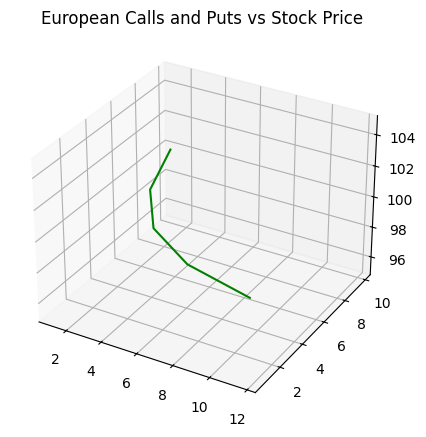

In [39]:
# Plot graphs
fig = plt.figure(figsize = (5,5))
ax = plt.axes(projection='3d')
ax.grid()

x = euro_data.Euro_call_price
y = euro_data.Euro_put_price
z = euro_data.Stock_price

# plotting
ax.plot3D(x, y, z, 'green')
ax.set_title('European Calls and Puts vs Stock Price')
plt.show()

**20. American Trinomial for Calls, Puts & Stock Prices**

In [40]:
american_raw_data = pd.DataFrame([american_call_array, american_put_array, stock_prices, strike_prices])
american_data = american_raw_data.transpose()

In [41]:
american_data.columns = ["American_call_price", "American_put_price", "Stock_price", "Strike_price"]
american_data.round(2)

,American_call_price,American_put_price,Stock_price,Strike_price
0,92.83,65.69,100.0,90.0
1,91.36,70.69,100.0,95.0
2,89.88,75.69,100.0,100.0
3,88.40,80.69,100.0,105.0
4,86.92,85.69,100.0,110.0


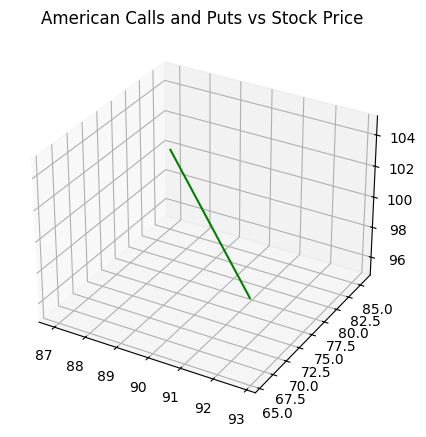

In [42]:
# plot graph
fig = plt.figure(figsize = (5,5))
ax = plt.axes(projection='3d')
ax.grid()

x = american_data.American_call_price
y = american_data.American_put_price
z = american_data.Stock_price

# plotting
ax.plot3D(x, y, z, 'green')
ax.set_title('American Calls and Puts vs Stock Price')
plt.show()

**21. European Trinomial for Calls, Puts & Strike Prices**

Text(0.5, 0.92, 'European Calls and Puts vs Strike Price')

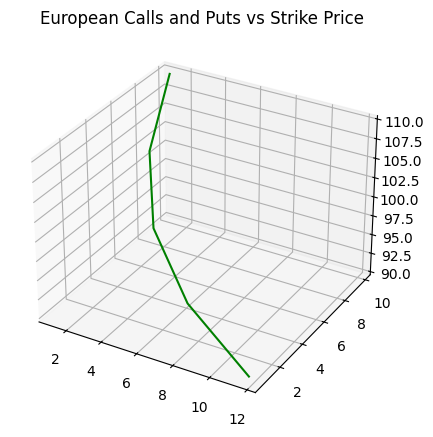

In [43]:
# plot of European Call, Put & Strike prices
fig = plt.figure(figsize = (5,5))
ax = plt.axes(projection='3d')
ax.grid()

x = euro_data.Euro_call_price
y = euro_data.Euro_put_price
z = euro_data.Strike_price


# plotting
ax.plot3D(x, y, z, 'green')
ax.set_title('European Calls and Puts vs Strike Price')

**22. American Trinomial for Calls, Puts & Strike Prices**

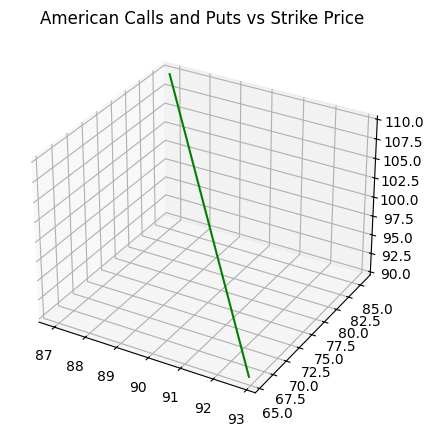

In [44]:
# Plot graph
fig = plt.figure(figsize = (5,5))
ax = plt.axes(projection='3d')
ax.grid()

x = american_data.American_call_price
y = american_data.American_put_price
z = american_data.Strike_price

# plotting
ax.plot3D(x, y, z, 'green')
ax.set_title('American Calls and Puts vs Strike Price')
plt.show()

**23. Put-Call Parity Test for European Options**



***For Put-Call Parity to hold: C + Kexp(-rdt) = S_ini + P***

In [45]:
S_ini_ = 100
discount = 0.9998 # (Kexp(-rT))
def assert_euro_put_call_parity(euro_call_price, euro_put_price,K, S_ini_, discount, tolerance=1e-5):



    lhs = euro_call_price +  K * discount
    rhs = euro_put_price + S_ini_

    return abs(lhs - rhs) <= tolerance


    for K in [90,95,100,105,110]:
        for euro_call_price in euro_call_array:
            for euro_put_price in euro_put_array:
                if assert_euro_put_call_parity(euro_call_price, euro_put_price,K, S_ini_, discount):
                    print(f"Put-call parity holds for strike price {K} and call price {euro_call_price}, and put price {euro_put_price}.")
                else:
                    print(f"Put-call parity does NOT hold for strike price {K} and call price {euro_call_price}, and put price {euro_put_price}..")




In [46]:
assert_euro_put_call_parity(euro_call_price, euro_put_price,K, S_ini_, discount)

False

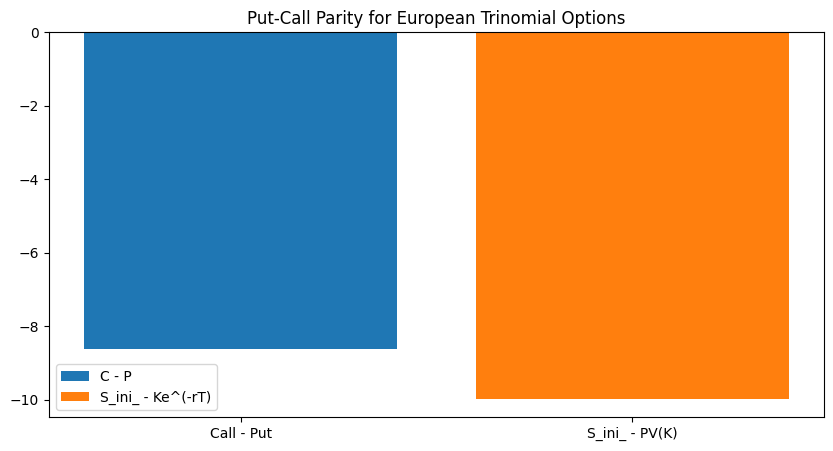

In [47]:
# Plot European Put-Call Parity Verification
plt.figure(figsize=(10, 5))
plt.bar(["Call - Put"], [euro_call_price - euro_put_price], label="C - P")
plt.bar(["S_ini_ - PV(K)"], [S_ini_ - (K * discount)], label="S_ini_ - Ke^(-rT)")
plt.title("Put-Call Parity for European Trinomial Options")
plt.legend()
plt.show()

Put-Call Parity does not hold true for European Options using a trinomial tree. Here's why:

- Small deviations across several time step accumulate into significant small arbitrage values - which eventually result in disequilibrium between Put-Call Pariity Equation.

- Discount interest rate modelling over time tend to affect parity balance as the accumulation rounded decimal values create some form of arbritrage.

- Dividend adjustments over each time step (for dividend paying stocks) will significantly alter stock market price and as such cause in imbalance in the parity equation.

**24. Put-Call Parity Test for American Options**

In [48]:
S_ini_ = 100
discount = 0.9998 # (Kexp(-rT))
def assert_american_put_call_parity(american_call_price, american_put_price,K, S_ini_, discount, tolerance=1e-5):

    lhs = american_call_price +  K * discount
    rhs = american_put_price + S_ini_

    return abs(lhs - rhs) <= tolerance


    for K in [90,95,100,105,110]:
        for american_call_price in american_call_array:
            for american_put_price in american_put_array:
                if assert_american_put_call_parity(american_call_price, american_put_price,K, S_ini_, discount):
                    print(f"Put-call parity holds for strike price {K} and call price {american_call_price}, and put price {american_put_price}.")
                else:
                    print(f"Put-call parity does NOT hold for strike price {K} and call price {american_call_price}, and put price {american_put_price}..")



In [49]:
 assert_american_put_call_parity(american_call_price, american_put_price,K, S_ini_, discount)

False

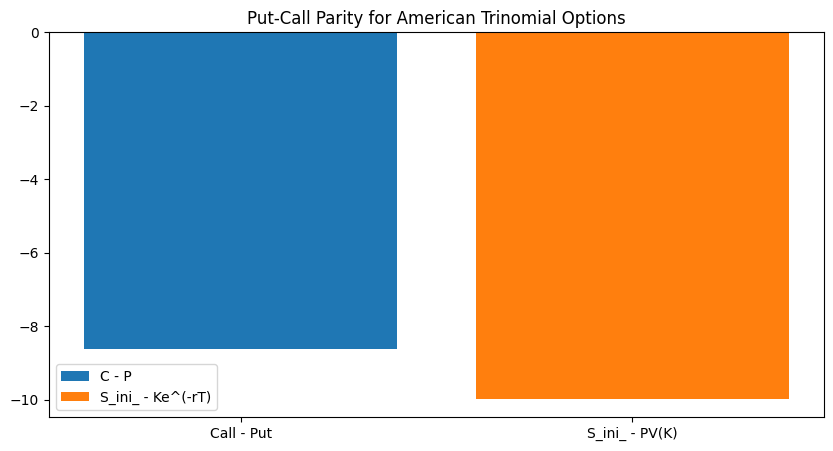

In [50]:
# Plot American Put-Call Parity Verification
plt.figure(figsize=(10, 5))
plt.bar(["Call - Put"], [euro_call_price - euro_put_price], label="C - P")
plt.bar(["S_ini_ - PV(K)"], [S_ini_ - (K * discount)], label="S_ini_ - Ke^(-rT)")
plt.title("Put-Call Parity for American Trinomial Options")
plt.legend()
plt.show()

Put-Call Parity does not hold true for American Options using a trinomial tree. Here's why:

- Friction market/transaction costs such as bid-ask spreads, stock maintenance fees can alter the equilibrium of the portfolio that normally would hold put-call equivalence

- Flexibility of Early Exercise: Volatilty of Stock price may result in the early exercise of an American option, hence, the payoff equivalence is not fixed at any time before expiration, The sudden price changes affect put call parity as a deep ITM put payoff might not reflect in the overall portfolio that matches this payoff.

- Dividend adjustments over each time step (for dividend paying stocks) will significantly alter stock market price and as such cause in imbalance in the parity equation.

- Payoff depends on the path and discrete time step.The potential outcomes for each step alters the outcome for subsequent step whcih on turn result in payoff asymmetry and parity imbalance.

# **Step 3: Dynamic Delta Hedging**

**25. European Put Option - Using Binomial Tree**


**Parameters**

- S0 =180,
- r = 2%
- sigma = 25%
- T = 6months
- K = 182
- N = 3

In [51]:
import math

# Parameters
S0 = 180  # Initial stock price
K = 182   # Strike price
r = 0.02  # Risk-free interest rate
sigma = 0.25  # Volatility
T = 0.5  # Time to maturity in years
N = 3    # Steps in binomial tree

def binomial_put_price(S, K, r, sigma, T, N):
    if N <= 0:
        return max(K - S, 0)  # Return the payoff at expiration
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    p = (math.exp(r * dt) - d) / (u - d)
    prices = [S * (u ** (N - i)) * (d ** i) for i in range(N + 1)]
    values = [max(K - S, 0) for S in prices]

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            values[j] = (p * values[j] + (1 - p) * values[j + 1]) * math.exp(-r * dt)
    return values[0]

def calculate_delta(S, K, r, sigma, T, N):
    if N <= 0:
        return -1 if S < K else 0  # Return -1 if in-the-money, 0 otherwise
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    delta = (binomial_put_price(S * u, K, r, sigma, T - dt, N - 1) -
             binomial_put_price(S * d, K, r, sigma, T - dt, N - 1)) / (S * u - S * d)
    return delta

def delta_hedging_process(S0, K, r, sigma, T, N):
    option_price = binomial_put_price(S0, K, r, sigma, T, N)
    print(f"European Put Option Price: ${option_price:.2f}")
    print("\nDelta Hedging Process:")
    print("Step | Stock Price | Delta (shares) | Cash Account")
    print("-" * 55)

    S = S0
    cash_account = 0.0
    prev_delta = 0.0

    for i in range(N + 1):
        delta = calculate_delta(S, K, r, sigma, max(T - i * T / N, 0), max(N - i, 0))
        shares_to_sell = delta - prev_delta
        cash_account -= shares_to_sell * S
        print(f"{i:4d} | ${S:11.2f} | {delta:14.2f} | ${cash_account:12.2f}")
        S *= math.exp(sigma * math.sqrt(T / N))  # Assume upward move
        prev_delta = delta

# Run the delta hedging process
delta_hedging_process(S0, K, r, sigma, T, N)

European Put Option Price: $13.82

Delta Hedging Process:
Step | Stock Price | Delta (shares) | Cash Account
-------------------------------------------------------
   0 | $     180.00 |          -0.47 | $       85.06
   1 | $     199.34 |          -0.24 | $       39.17
   2 | $     220.76 |           0.00 | $      -14.33
   3 | $     244.48 |           0.00 | $      -14.33


**26 American Put Option - Using Binomial Tree**

In [52]:
# Parameters
S0 = 180       # Initial stock price
K = 182        # Strike price
T = 0.5        # Maturity in years (6 months)
r = 0.02       # Risk-free rate (2%)
sigma = 0.25   # Volatility (25%)
n_steps = 25   # Number of steps in the binomial tree


In [53]:
# Binomial Tree Setup
dt = T / n_steps                            # Time increment
u = np.exp(sigma * np.sqrt(dt))             # Up factor
d = 1 / u                                   # Down factor
p = (np.exp(r * dt) - d) / (u - d)          # Risk-neutral probability

# Initialize asset price tree
asset_tree = np.zeros((n_steps + 1, n_steps + 1))
asset_tree[0, 0] = S0

for i in range(1, n_steps + 1):
    for j in range(i + 1):
        asset_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)

# Initialize option value tree for an American put
option_tree = np.zeros((n_steps + 1, n_steps + 1))
for j in range(n_steps + 1):
    option_tree[j, n_steps] = max(K - asset_tree[j, n_steps], 0)

# Backward induction for option price and delta calculation
delta_tree = np.zeros((n_steps, n_steps))
for i in range(n_steps - 1, -1, -1):
    for j in range(i + 1):
        # Option value at this node (American)
        hold_value = np.exp(-r * dt) * (p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1])
        exercise_value = max(K - asset_tree[j, i], 0)
        option_tree[j, i] = max(hold_value, exercise_value)

        # Delta (hedge ratio)
        delta_tree[j, i] = (option_tree[j, i + 1] - option_tree[j + 1, i + 1]) / (asset_tree[j, i] * (u - d))

# Select a path (e.g., always "up" path for simplicity)
cash_account = [0]
deltas = [delta_tree[0, 0]]
path_asset_price = [S0]
path_option_value = [option_tree[0, 0]]

for i in range(n_steps):
    # Simulate asset price movement
    price_up = path_asset_price[-1] * u
    price_down = path_asset_price[-1] * d

    # Assume the path goes "up" at every step for simplicity
    next_price = price_up
    next_option_value = option_tree[0, i + 1] if i + 1 < n_steps else 0
    next_delta = delta_tree[0, i + 1] if i + 1 < n_steps else 0

    # Update cash account (amount needed to rebalance)
    cash_account.append(cash_account[-1] * np.exp(r * dt) + deltas[-1] * (path_asset_price[-1] - next_price))

    # Update path values for each step
    path_asset_price.append(next_price)
    path_option_value.append(next_option_value)
    deltas.append(next_delta)


In [54]:
# Output the values along the path
for i in range(n_steps):
    print(f"Step {i + 1}:")
    print(f"  Asset Price: {path_asset_price[i]:.2f}")
    print(f"  Option Value: {path_option_value[i]:.2f}")
    print(f"  Delta Hedge: {deltas[i]:.4f}")
    print(f"  Cash Account: {cash_account[i]:.2f}\n")

# Comments on Delta Hedging for American vs European Options
print("Delta hedging for an American option is more complex than for a European option, as we must account for the early exercise feature.")
print("This means that the delta may change abruptly if it becomes optimal to exercise the option early, which affects the stability and predictability of the hedging strategy.")


Step 1:
  Asset Price: 180.00
  Option Value: 13.04
  Delta Hedge: -0.4756
  Cash Account: 0.00

Step 2:
  Asset Price: 186.48
  Option Value: 9.99
  Delta Hedge: -0.3951
  Cash Account: 3.08

Step 3:
  Asset Price: 193.19
  Option Value: 7.38
  Delta Hedge: -0.3163
  Cash Account: 5.73

Step 4:
  Asset Price: 200.14
  Option Value: 5.20
  Delta Hedge: -0.2423
  Cash Account: 7.93

Step 5:
  Asset Price: 207.34
  Option Value: 3.48
  Delta Hedge: -0.1760
  Cash Account: 9.68

Step 6:
  Asset Price: 214.81
  Option Value: 2.18
  Delta Hedge: -0.1200
  Cash Account: 11.00

Step 7:
  Asset Price: 222.54
  Option Value: 1.27
  Delta Hedge: -0.0758
  Cash Account: 11.93

Step 8:
  Asset Price: 230.54
  Option Value: 0.67
  Delta Hedge: -0.0435
  Cash Account: 12.54

Step 9:
  Asset Price: 238.84
  Option Value: 0.31
  Delta Hedge: -0.0221
  Cash Account: 12.91

Step 10:
  Asset Price: 247.44
  Option Value: 0.12
  Delta Hedge: -0.0096
  Cash Account: 13.10

Step 11:
  Asset Price: 256.34
  

**27. Asian ATM Put Option - Using Binomial Tree**

**Parameters**

- S0 = 182 (Initial stock price for ATM Put Option)
- r = 0.02       (Risk-free rate)
- sigma = 0.25  (Volatility)
- T = 6 / 12     (Time to expiration in years (6 months))
- K = 182       (Strike price (ATM option))

In [55]:
def binomial_asian_put_delta_hedging(S0, K, r, T, sigma, N):
    """
    Perform delta hedging of an Asian put option using a binomial tree approach.

    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - r: Risk-free interest rate
    - T: Time to maturity (in years)
    - sigma: Volatility of the underlying asset
    - N: Number of steps in the binomial tree

    Returns:
    - option_price: Price of the Asian put option from the perspective of the seller
    - cash_flows: List of cash flows at each step due to re-hedging
    """
    dt = T / N  # Time increment
    u = np.exp(sigma * np.sqrt(dt))  # Up movement factor
    d = 1 / u  # Down movement factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Initialize stock price tree
    stock_tree = np.zeros((N + 1, N + 1))
    stock_tree[0, 0] = S0

    # Fill the stock price tree
    for i in range(1, N + 1):
        stock_tree[i, 0] = stock_tree[i - 1, 0] * u
        for j in range(1, i + 1):
            stock_tree[i, j] = stock_tree[i - 1, j - 1] * d

    # Initialize option value and delta trees
    option_tree = np.zeros((N + 1, N + 1))
    delta_tree = np.zeros((N, N))

    # Calculate average stock prices at maturity
    avg_price = np.zeros(N + 1)
    for i in range(N + 1):
        avg_price[i] = np.mean(stock_tree[i, :i+1])

    # Set option values at maturity
    for j in range(N + 1):
        option_tree[N, j] = max(K - avg_price[j], 0)

    # Backward induction through the tree
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            avg_price[j] = (stock_tree[i, j] + j * avg_price[j]) / (j + 1)
            option_value_up = option_tree[i + 1, j]
            option_value_down = option_tree[i + 1, j + 1]
            option_tree[i, j] = np.exp(-r * dt) * (p * option_value_up + (1 - p) * option_value_down)

            # Delta calculation
            delta_tree[i, j] = (option_value_up - option_value_down) / (stock_tree[i, j] * (u - d))

    # Delta hedging and cash flow tracking
    cash_flows = []
    stock_position = 0  # Initial stock position for hedging

    for i in range(N):
        delta_needed = delta_tree[i, 0]  # Delta at this step
        stock_price = stock_tree[i, 0]

        # Cash flow due to adjusting delta (buy/sell stock)
        cash_flow = (delta_needed - stock_position) * stock_price
        cash_flows.append(cash_flow)

        # Update stock position
        stock_position = delta_needed

    # Discount cash flows to get total cost of hedging
    discounted_cash_flows = sum([cf * np.exp(-r * i * dt) for i, cf in enumerate(cash_flows)])

    # Option price for seller (total hedging cost)
    option_price = option_tree[0, 0]
    hedged_price = option_price - discounted_cash_flows

    return delta_tree, cash_flows, option_price,  hedged_price

# Example parameters
S0 = 182      # Initial stock price
K = 182        # Strike price
r = 0.02       # Risk-free rate
T = 6/12          # Time to maturity (1 year)
sigma = 0.25    # Volatility
N = 25         # Number of time steps in binomial tree

delta_tree, cash_flows, option_price,  hedged_price = binomial_asian_put_delta_hedging(S0, K, r, T, sigma, N)

print("Delta:", delta_tree)
print("Cash flows due to delta hedging at each step:", cash_flows)
print("Option Price:", option_price)
print("The hedged price of the Asian put option for the seller is:", hedged_price)


Delta: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

**Difference between Asian ATM option and European Option**
The Asian ATM does results for delta for all steps because at *stock averaging* across steps results in delta very close to zero. The option payoff is path dependent, hence a small variation in the stock price along a path will result in a corresponding change in the payoff an intrinsic value of the option and consequently bringing the delta back to zero. Therefore, the seller does not require hedging for a delta of 0.

The hedging process for European put option is almost ATM - as the strike price and iinitial stock price are very close. Unlike the Asian put option, the European option allows for option price hedging. This because delta is negative and close to -0.5. Interestingly, the seller would have to adjust option position as the underlying stock prices changes and delta becomes less negative (approaches 0). Naturally, the seller of the put option hopes that the stock exceeds the strike price at expiration (ITM) but if the reverse happens, the seller would have to go long on the option to mitigate potential losses at maturity. In essence, there is a dynamism in hedging and re-hedging process before option expiration.

**Difference between Asian ATM option and American Option**.

Unlike the Asian option, there is hedge price for the seller of an American option (which is even more valuable than that of the European option becuase of the flexibility of early exercise. The American put opton that is almost ATM is riskier to the seller than the European option, hence there is need for hedging and re-hedging of position.